In [1]:
from langgraph.graph import StateGraph, END
from core.agent import llm
from typing import TypedDict
from langgraph.checkpoint.memory import InMemorySaver

class AgentState(TypedDict):
    response: str
    user_input: str
    load_memories: list[str]
    memory_loaded: bool
    context: str


# Creamos los nodos correspondientes


def user_prompt(state: AgentState) -> AgentState:
    """Este nodo recibe el prompt por parte del usuario"""
    if 'load_memories' not in state:
        state['load_memories'] = []

    state['load_memories'].append(f"Usuario: {state['user_input']}")
    state['memory_loaded'] = False
    return state


def recall_memory(state: AgentState) -> AgentState:
    """
    Acá se recupera la conversación que se ha tenido con el usuario
    generando una respuesta por parte del llm

    """
    try:
        memory_context = ""
        if state['load_memories']:
            return_conversation = state['load_memories'][-20:]
            memory_context = "\n".join(return_conversation)

        state['context'] = memory_context if memory_context else "No hay conversación previa."
        state['memory_loaded'] = True

    except Exception as e:
        state['context'] = f"Error al cargar el contexto de la conversación."
        state['memory_loaded'] = False

    return state


def initialize_agent(state: AgentState) -> AgentState:
    """Este nodo carga el agente virual configurado"""
    user_message = state['user_input']
    context = state.get('context', 'No tengo contexto previo')
    AGENT_IA = "Doris"

    prompt = f"""
    Eres {AGENT_IA} un asistente virtual que mantiene contexto de conversaciones.

    Contexto de la conversación previamente
    {context}

    El usuario te ha preguntado: {user_message}

    Responde de manera natural, teniendo en cuenta el contexto de la conversación si es relevante.
    """

    try:
        llm_response = llm.invoke(prompt)
        agent_response = llm_response.content
        state['response'] = agent_response

        # En este punto agregamos la conversación al estado
        state['load_memories'].append(f"{AGENT_IA}: {agent_response}")
    except Exception as e:
        exception_message = f"Lo siento pero no tengo una respuesta válida para esa solicitud, {str(e)}"
        state['response'] = exception_message
        state['load_memories'].append(f"{AGENT_IA}: {exception_message}")

    return state

python-dotenv could not parse statement starting at line 1


In [2]:
# actualizamos el estado del gráfico


graph = StateGraph(AgentState)


graph.add_node("user_prompt", user_prompt)
graph.add_node("recall_memory", recall_memory)
graph.add_node("initialize_agent", initialize_agent)


graph.set_entry_point("user_prompt")

graph.add_edge("user_prompt", "recall_memory")
graph.add_edge("recall_memory", "initialize_agent")
graph.add_edge("initialize_agent", END)


memory = InMemorySaver()


graph_compiled = graph.compile(checkpointer=memory)

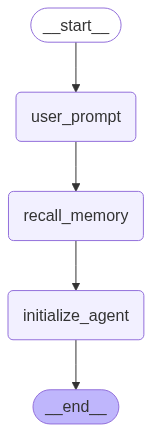

In [9]:
from IPython.display import Image, display

display(Image(graph_compiled.get_graph().draw_mermaid_png()))